In [1]:
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

from matplotlib import pyplot as plt
import sklearn.preprocessing as prep
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import time
import os

Using TensorFlow backend.


# Loading Data

In [2]:
os.chdir('Data')
os.listdir()

['prices-split-adjusted.csv',
 'RedditNews.csv',
 '.DS_Store',
 'fundamentals.csv',
 'datafest2018-Updated-April12.csv',
 'prices.csv',
 'Stocks',
 'ETFs',
 'securities.csv',
 'all_stocks_5yr.csv']

In [3]:
data = pd.read_csv('all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
data.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


# Preprocessing

Testing only with Apple Stock first

In [5]:
# feature for testing: 
# - closing price of the day
# - volume
# - absolute difference of high - low to measure fluctuation
features = ['close','volume','diff']
    
AAPL = data[data['Name']=='AAPL']
AAPL['diff'] =  abs(AAPL.high - AAPL.low)
AAPL = AAPL[features]
print('Shape:',AAPL.shape)

Shape: (1259, 3)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


A simple plot of features

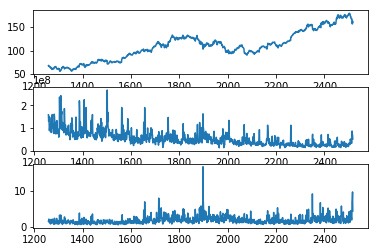

In [6]:
for idx,feature in enumerate(features):
    plt.subplot(len(features),1,idx+1)
    plt.plot(AAPL[feature])
plt.show()

Standardize Input

In [7]:
scalerX = prep.MinMaxScaler()
AAPL = scalerX.fit_transform(AAPL)
print(AAPL.shape)

(1259, 3)


Reframe to supervised learning

Input Dimension: (1253, 5, 3)
Output Dimension:  (1253,)


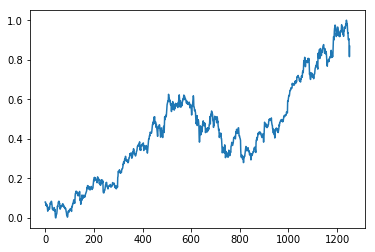

In [58]:
ts = 5
X,y = [],[]
for i in range(AAPL.shape[0]-ts-1):
    X.append(AAPL[i:i+ts])
    y.append(AAPL[i+ts,0])
X = np.array(X)
y = np.array(y)
print('Input Dimension:',X.shape)
print('Output Dimension: ',y.shape)
plt.plot(y)
plt.show()

Split Train Test Data

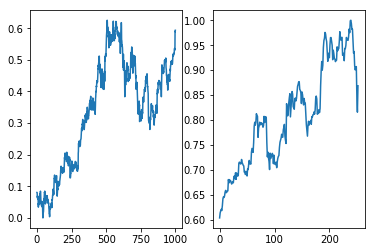

(1000, 5, 3)

In [59]:
X_train,X_test,y_train,y_test = X[:1000],X[1000:],y[:1000],y[1000:]
plt.figure()
plt.subplot(1,2,1)
plt.plot(y_train)
plt.subplot(1,2,2)
plt.plot(y_test)
plt.show()
X_train.shape

# LSTM Model


In [89]:
model = Sequential()

model.add(LSTM(256,input_shape = (5,3),return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(32,return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(32,return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse',optimizer='rmsprop')
print(time.time()-start)

lstm = model.fit(X_train,y_train,epochs = 30,batch_size=128,validation_split=0.1,shuffle=True)


0.023853778839111328
Train on 900 samples, validate on 100 samples
Epoch 1/30
900/900 [==============================] - 7s 8ms/step - loss: 0.0527 - val_loss: 0.0147
Epoch 2/30
900/900 [==============================] - 1s 633us/step - loss: 0.0089 - val_loss: 0.0094
Epoch 3/30
900/900 [==============================] - 1s 650us/step - loss: 0.0062 - val_loss: 0.0044
Epoch 4/30
900/900 [==============================] - 1s 631us/step - loss: 0.0059 - val_loss: 0.0043
Epoch 5/30
900/900 [==============================] - 1s 644us/step - loss: 0.0035 - val_loss: 0.0156
Epoch 6/30
900/900 [==============================] - 1s 640us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 7/30
900/900 [==============================] - 1s 689us/step - loss: 0.0045 - val_loss: 0.0033
Epoch 8/30
900/900 [==============================] - 1s 647us/step - loss: 0.0057 - val_loss: 0.0016
Epoch 9/30
900/900 [==============================] - 1s 647us/step - loss: 0.0037 - val_loss: 0.0091
Epoch 10/30
900/9

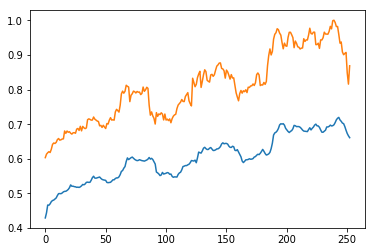

In [90]:
predictions = model.predict(X_test)

plt.plot(predictions)
plt.plot(y_test)

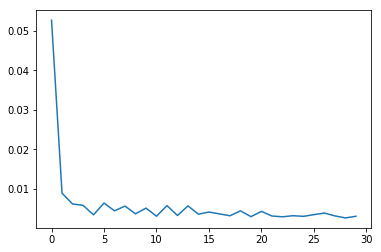

In [91]:
plt.plot(lstm.history['loss'])